In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Starter
* Data -> Build Dataset -> split dataset
* vocab
* init_MLP_params
* training
* loss
* sampling

In [2]:
words = open("names.txt").read().splitlines()
len(words), words[:10]

(32033,
 ['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'])

In [3]:
vocab = sorted(set(''.join(words)))

stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos) # Used for initiate emb lookup table

In [4]:
block_size = 3
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        context = [0] * block_size
        for ch in word+".":
            idx = stoi[ch]
            xs.append(context), ys.append(idx)
            context = context[1:] + [idx]
    xs, ys = torch.tensor(xs), torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

import random
random.seed(42)
random.shuffle(words)
train_idx = int(0.8 * len(words))
val_idx   = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:train_idx])
x_val  , y_val   = build_dataset(words[train_idx:val_idx])
x_test , y_test  = build_dataset(words[val_idx:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Kaiming Initing

mean: -0.007251, 0.005944
std : 1.003, 3.129


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00,
        5.0000e+00, 7.0000e+00, 1.9000e+01, 2.1000e+01, 5.5000e+01,
        9.3000e+01, 1.6800e+02, 2.9500e+02, 4.8800e+02, 7.5300e+02,
        1.1910e+03, 1.8230e+03, 2.8820e+03, 4.2460e+03, 6.0180e+03,
        8.6040e+03, 1.1057e+04, 1.4113e+04, 1.6953e+04, 1.9258e+04,
        2.0048e+04, 1.9321e+04, 1.7415e+04, 1.4544e+04, 1.1669e+04,
        9.0450e+03, 6.6300e+03, 4.5540e+03, 3.1450e+03, 2.0800e+03,
        1.3700e+03, 7.9200e+02, 4.9300e+02, 3.3200e+02, 2.0500e+02,
        1.2900e+02, 7.5000e+01, 3.1000e+01, 3.0000e+01, 1.5000e+01,
        1.1000e+01, 6.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-18.59992599, -17.87339142, -17.14685684, -16.42032227,
        -15.69378769, -14.96725311, -14.24071854, -13.51418396,
        -12.78764938, -12.06111481, -11.33458023, -10.60804565,
         -9.88151108,  -9.1549765 ,  -8.42844193,  -7.70190735,
         -6.97537277,  -6.2488382 ,  -5.52230362,  -4.79576904

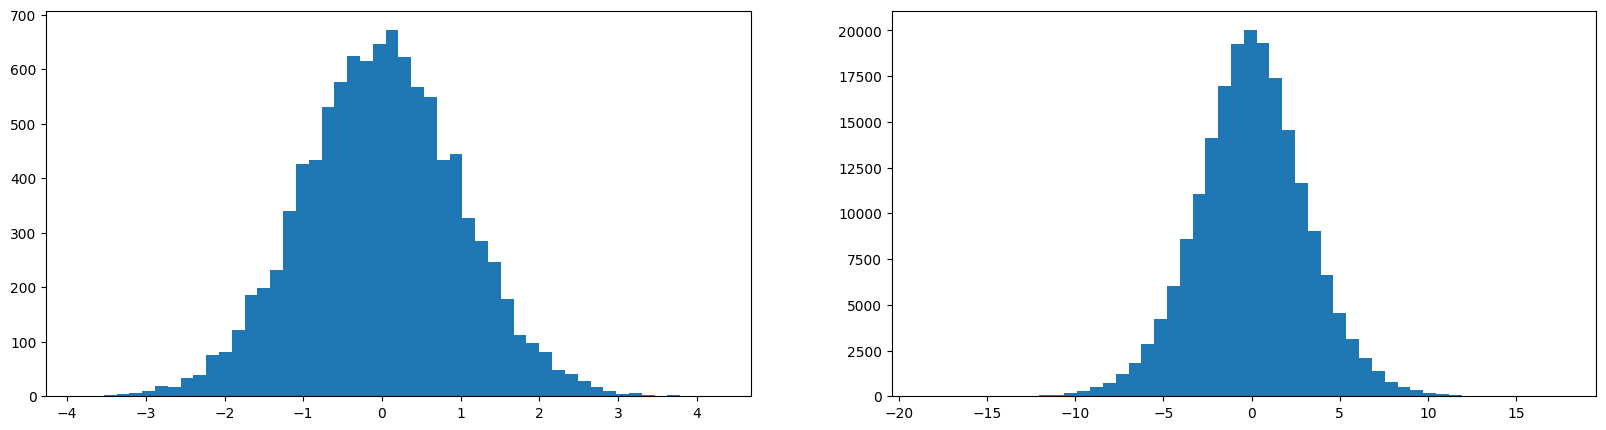

In [37]:
x = torch.randn((1000, 10))
w = torch.randn((10, 200))
w = torch.randn((10, 200)) / 10 ** 0.5
y = x @ w
print(f"mean: {x.mean():.4}, {y.mean():.4}")
print(f"std : {x.std():.4}, {y.std():.4}")
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), 50)
# We need to scale the w to have y.std() close to 1.

scale: $\frac{gain}{\sqrt{fan-mode}}$

In [43]:
w_scale = (5 / 3) / (block_size * emb_dim)**0.5
w_scale

0.3042903097250923

In [44]:
emb_dim = 10
hidden_dim = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dim)              , generator=g)
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g) * w_scale
b1 = torch.randn(hidden_dim                        , generator=g) * 0.01
W2 = torch.randn((hidden_dim, vocab_size)          , generator=g) * 0.01
b2 = torch.randn(vocab_size                        , generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(f"Parameter number: {sum([p.nelement() for p in parameters])}")
for p in parameters:
    p.requires_grad = True

Parameter number: 11897


For the loss at first step, it was `27.8817` which is very large. It means that the model is very confidently wrong. Ideally, we expect the uniform probs distribution at initialization.

In [45]:
logits = torch.tensor([-0.5, 0.1, 2, 0])
probs = logits.exp() / logits.exp().sum(dim=0, keepdim=True)
loss = -probs[2].log().mean()
loss

tensor(0.3126)

In [46]:
max_steps  = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Forward
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = x_train[idx], y_train[idx] 
    
    emb = C[Xb]
    hpreact = emb.view(emb.shape[0], -1) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    
    # Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100000  else 0.01
    with torch.no_grad():
        for p in parameters:
            p += -lr * p.grad
            
    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


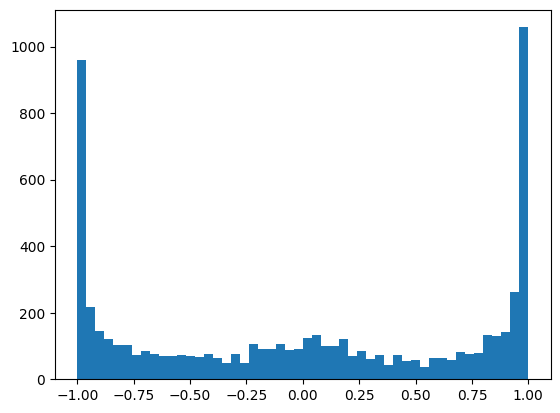

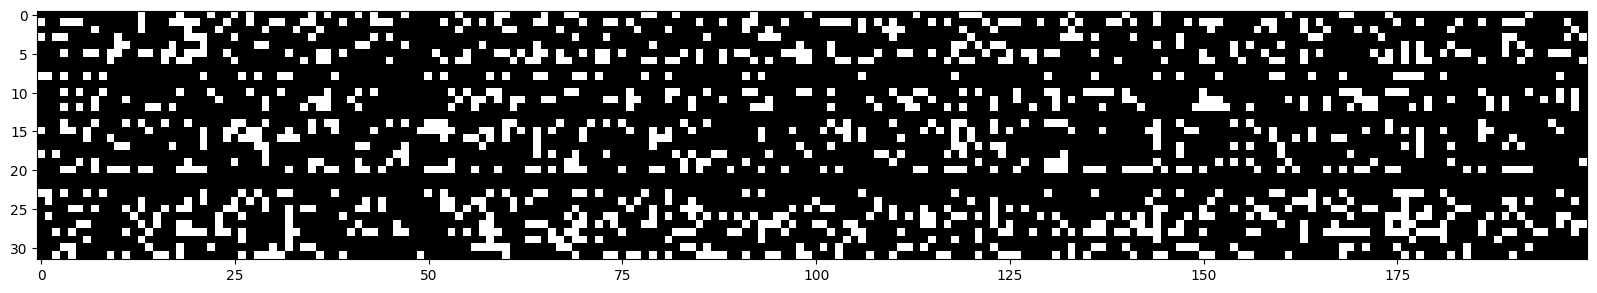

In [8]:
# Activation of hidden state
plt.hist(h.view(-1).tolist(), 50)
plt.figure(figsize=(20, 5))
plt.imshow(h.abs() > 0.99, cmap="gray")

(array([  1.,   0.,   0.,   3.,   3.,   3.,   4.,   6.,  11.,   9.,  18.,
         16.,  31.,  38.,  41.,  60.,  86., 120., 158., 160., 222., 231.,
        279., 367., 463., 711., 904., 400., 327., 320., 275., 250., 213.,
        188., 115.,  87.,  70.,  55.,  35.,  30.,  32.,  19.,  16.,   4.,
          4.,   4.,   6.,   4.,   0.,   1.]),
 array([-9.7466898 , -9.37282412, -8.99895844, -8.62509275, -8.25122707,
        -7.87736139, -7.50349571, -7.12963003, -6.75576435, -6.38189867,
        -6.00803299, -5.63416731, -5.26030163, -4.88643595, -4.51257027,
        -4.13870459, -3.76483891, -3.39097322, -3.01710754, -2.64324186,
        -2.26937618, -1.8955105 , -1.52164482, -1.14777914, -0.77391346,
        -0.40004778, -0.0261821 ,  0.34768358,  0.72154926,  1.09541494,
         1.46928062,  1.84314631,  2.21701199,  2.59087767,  2.96474335,
         3.33860903,  3.71247471,  4.08634039,  4.46020607,  4.83407175,
         5.20793743,  5.58180311,  5.95566879,  6.32953447,  6.70340015,
 

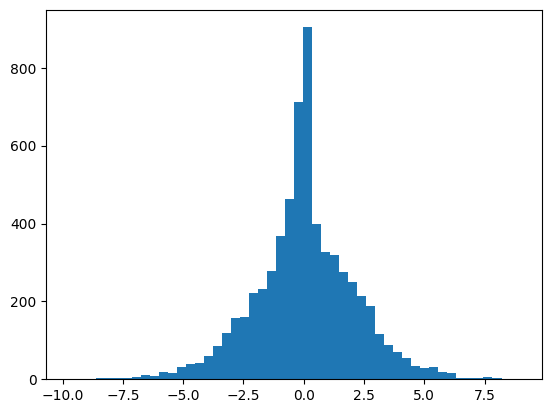

In [9]:
# The range before hidden layer is saturated.
plt.hist(hpreact.view(-1).tolist(), 50)

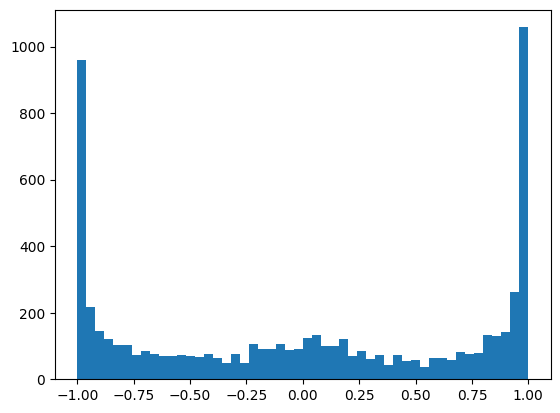

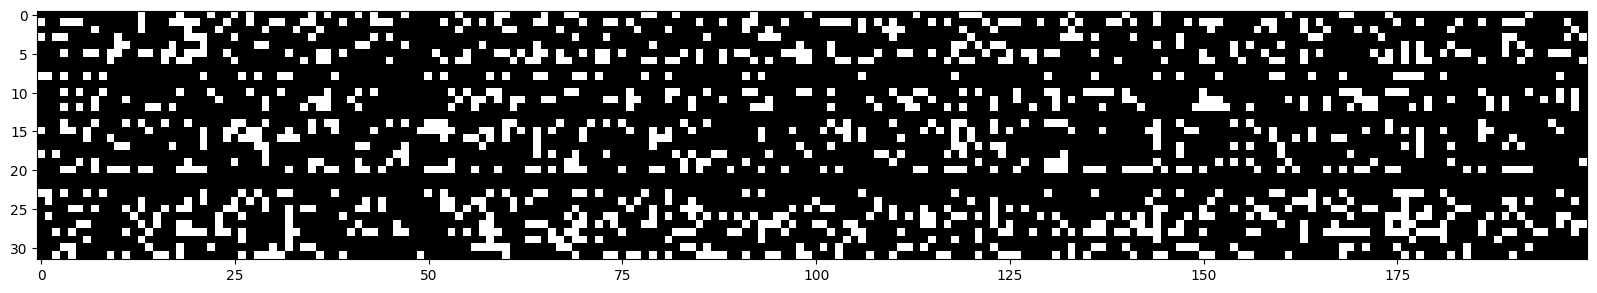

In [10]:
# Activation of hidden state after refinement
h_line = h.view(-1).tolist()
plt.hist(h_line, 50)
plt.figure(figsize=(20, 5))
plt.imshow(h.abs() > 0.99, cmap="gray")

(array([  1.,   0.,   0.,   3.,   3.,   3.,   4.,   6.,  11.,   9.,  18.,
         16.,  31.,  38.,  41.,  60.,  86., 120., 158., 160., 222., 231.,
        279., 367., 463., 711., 904., 400., 327., 320., 275., 250., 213.,
        188., 115.,  87.,  70.,  55.,  35.,  30.,  32.,  19.,  16.,   4.,
          4.,   4.,   6.,   4.,   0.,   1.]),
 array([-9.7466898 , -9.37282412, -8.99895844, -8.62509275, -8.25122707,
        -7.87736139, -7.50349571, -7.12963003, -6.75576435, -6.38189867,
        -6.00803299, -5.63416731, -5.26030163, -4.88643595, -4.51257027,
        -4.13870459, -3.76483891, -3.39097322, -3.01710754, -2.64324186,
        -2.26937618, -1.8955105 , -1.52164482, -1.14777914, -0.77391346,
        -0.40004778, -0.0261821 ,  0.34768358,  0.72154926,  1.09541494,
         1.46928062,  1.84314631,  2.21701199,  2.59087767,  2.96474335,
         3.33860903,  3.71247471,  4.08634039,  4.46020607,  4.83407175,
         5.20793743,  5.58180311,  5.95566879,  6.32953447,  6.70340015,
 

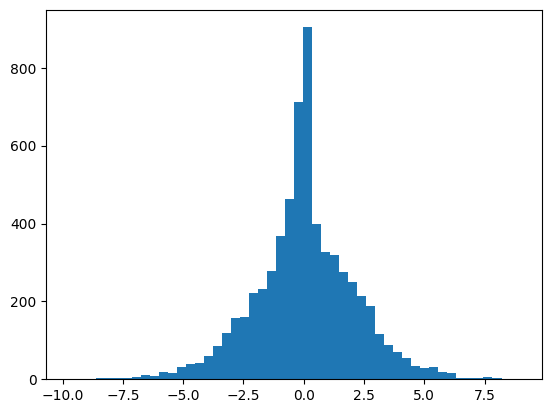

In [11]:
# The range before hidden layer is saturated.
plt.hist(hpreact.view(-1).tolist(), 50)

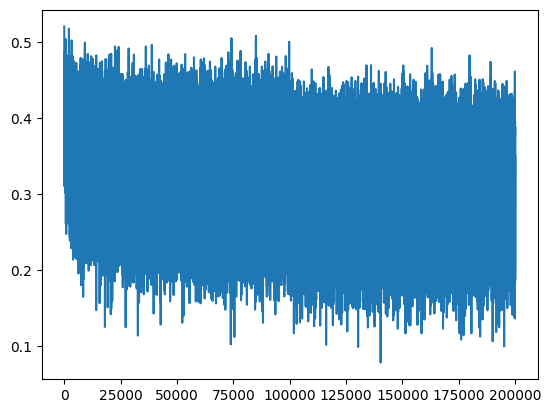

In [47]:
plt.plot(torch.arange(len(lossi)), lossi)

In [48]:
def split_loss(mode="train"):
    x, y = {
        "train": (x_train, y_train),
        "val"  : (x_val  , y_val),
        "test" : (x_test , y_test)
    }[mode]
    x = x_train if mode == "train" else x_val
    y = y_train if mode == "train" else y_val
    
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{mode} loss over the entire dataset is: {loss.item()}")
    
split_loss("train")
split_loss("val")

train loss over the entire dataset is: 2.0376644134521484
val loss over the entire dataset is: 2.106989622116089


Loss summary:

1. initial setting: train 2.1256, val 2.1698
2. revising logits uniform init: train 2.0695, val 2.1311
3. revising logits uniform init + fix saturated tanh: train 2.0355, val 2.1026
4. add kaiming init instead of hacky init: train: 2.0376, val: 2.1069

In [14]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # Sampling
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print(''.join([itos[i] for i in out]))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.
